# Simulating Monopoly

In this project I to model the board game Monopoly eventually calculate with which squares / properties have the highest expected return on investment (ROI) - the cost of purchasing the property and houses vs. expected income from owning.

I do this differently to the other attempts I have come across in that I choose to model a **large number of games consisting of a realistic number of goes**, rather than a **one game of a large number of goes** - the distinction is subtle but important, as outlined further below. 

This consists of first modelling the behviour of two dice, then a simple game to which I then incorporate jail and the decks of cards. I input the rents associated with each square using a webscrape and then calculate the ROIs. (I'll save the highly-anticipated answer for the end)


For those that are unfamiliar, this is a Monopoly board:

<img src="monopoly_board.jpg" style="width:200px;height:200px"/>

# Setting up the dice
Define a function that will roll two dice:

In [2]:
import random
random.seed(1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import requests
import lxml.html as lh
pd.options.mode.chained_assignment = None

In [3]:
def roll2dice():
    roll1=random.randint(1,6)
    roll2=random.randint(1,6)
    return roll1, roll2

Function for histogram of results:

In [4]:
def diceplot(x,y):
    plt.style.use('seaborn-pastel')
    plt.bar(x,y)
    plt.xticks(np.arange(2, len(counters)+1, 1.0))
    plt.xlabel('Value of 2 dice')
    plt.ylabel('Probability')
    plt.title('Probability distribution of summed values of two dice')

In [5]:
# Create array to store frequency / probability of each value
counters=np.zeros([12],float)
rolls=0
max_rolls=1000000
while rolls < max_rolls:
    roll1,roll2=roll2dice()
    total=roll1+roll2
    counters[total-1]+=1
    rolls+=1
for i in range(len(counters)):
    counters[i]=counters[i]/max_rolls

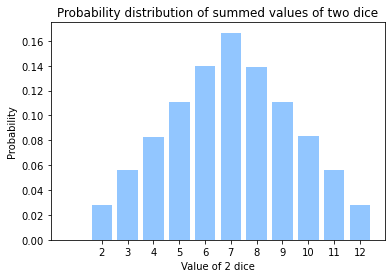

In [6]:
diceplot(range(1,len(counters)+1),counters)

# Monopoly game
Having set out mechanisms for dice, can start to model a simple monopoly game.

First, ellaborate on the dice function to replicate what happens in monopoly: if player rolls a double, you move forward the combined sum from the first roll and roll again. If this second roll is also a double,  player moves forward and rolls for a third time. If this third roll is also a double, however, the player goes to jail.

In [7]:
def doublecheck(roll1,roll2):
    double_check=0
    if roll1==roll2:
        double_check=1
    else:
        double_check=0
    return double_check

Out of interest, what is the probability of going to jail in this way?

In [8]:
max_rolls=10000
rolls=0
doublecounter=0
triplecounter=0
while rolls<max_rolls:
    roll1,roll2=roll2dice()
    double_check=doublecheck(roll1,roll2)
    if double_check==1:
        doublecounter+=1
    else:
        doublecounter=0
    #print(roll1,roll2,doublecounter)
    if doublecounter==3:
        triplecounter+=1
        doublecounter=0
    rolls+=1
x =(1/6)**3 # ===> probability of a double is 1/6 x 1/6 x 6
print("Probability of getting a triple is "+"{:.3%}".format(x))
print("%d instances of rolling 3 doubles in a row after rolling two dice %d times" %(triplecounter,max_rolls))

Probability of getting a triple is 0.463%
36 instances of rolling 3 doubles in a row after rolling two dice 10000 times


# Basic, board only Monopoly game:

Function to plot the distribution:

In [8]:
def monplot(x,y,n_goes_string,n_squares):
    plt.style.use('seaborn-pastel')
    plt.bar(x,y)
    plt.xticks(np.arange(min(n_squares), max(n_squares)+1, 2.0))
    plt.xlabel('Monopoly board square')
    plt.ylabel('Probability of landing on square')
    plt.title('Probability distribution of the monopoly board after ' +n_goes_string+' goes',size=14)

In [9]:
def basic_play(n_goes):
    n_goes=n_goes
    n_goes_string= '{:,}'.format(n_goes)
    nsquares=40
    board_counters=np.zeros([nsquares],float)
    currentposition=0
    roll=0
    while roll < n_goes:
        double_check=0
        roll1,roll2=roll2dice()
        total=roll1+roll2
        #print(roll1,roll2)
        double_check=doublecheck(roll1,roll2)
        if double_check==1:
            roll1,roll2=roll2dice()
            total+=roll1+roll2
            #print(roll1,roll2)
        else:
            pass
        currentposition=(currentposition+total)%nsquares
        #print(currentposition)
        board_counters[currentposition]+=1
        roll+=1
    for i in range(len(board_counters)):
        board_counters[i]=board_counters[i]/n_goes
    index=list(range(len(board_counters)))
    probs=pd.DataFrame({'Probability':board_counters}, index=index)
    monplot(probs.index,probs.Probability,n_goes_string,index)

# Incorporating a jail
Define some functions to describe how one goes to and escapes from jail. Rolling three doubles or landing on the 'go to jail' square (square 30) will send you to jail (note that jail itself is located on square 10).

In [10]:
def jailcheck(currentposition,doublecount):
    in_jail=0
    if currentposition==30 or doublecount==3:
        in_jail=1
        currentposition=10
        #print("You are in jail!")
    else:
        currentposition=currentposition
    return currentposition, in_jail

In [11]:
def doubles_play(currentposition):
    roll1,roll2=roll2dice()
    #print(roll1,roll2)
    double_check=doublecheck(roll1,roll2)
    doublecount=0
    currentposition=(currentposition+roll1+roll2)%nsquares
    #print(currentposition)
    if double_check==1:
        doublecount+=1
        while double_check==1 and doublecount <3:
            roll1,roll2=roll2dice()
            #print(roll1,roll2)
            double_check=doublecheck(roll1,roll2)
            currentposition = (currentposition+roll1+roll2)%nsquares
            if double_check==1:
                doublecount+=1
            else:
                pass
        else:
            pass
    currentposition, in_jail=jailcheck(currentposition,doublecount)
    #print(currentposition)
    return currentposition, in_jail

To escape from jail a player must either roll a double or wait for three turns. If a player escapes jail early by rolling a double on one of the three turns they spend in jail, they advance as if they had rolled that double. 

In [12]:
def escape_jail(currentposition,in_jail):
    turnsinjail=1
    if in_jail==1:
        while turnsinjail < 4 and in_jail==1:
            roll1,roll2=roll2dice()
           #print(roll1,roll2)
            double_check=doublecheck(roll1,roll2)
            if double_check==1:
                in_jail=0
                currentposition=10+roll1+roll2
            else:
                turnsinjail+=1
        else:
            if in_jail==1:
                in_jail=0
                roll1,roll2=roll2dice()
                #print(roll1,roll2)
                currentposition=(10+roll1+roll2)%nsquares
    else:
        currentposition=currentposition
    return currentposition , turnsinjail , in_jail

Now test the mechanics (unsilence the print functions in the above functions before doing so):

In [248]:
nsquares=40

In [746]:
currentposition=0
turns=1
while turns<10:
    print("=>Turn number %d"%(turns))
    currentposition, in_jail=doubles_play(currentposition)
    currentposition=currentposition%nsquares
    print("Currentposition is %d"%(currentposition))
    if in_jail ==1:
        currentposition,turnsinjail, in_jail=escape_jail(currentposition, in_jail)  
        currentposition=currentposition%nsquares
        print("Currentposition is %d"%(currentposition))
        print("Spent %d turns in jail"%(turnsinjail-1))
        turns+=1+turnsinjail
    else:
        turns+=1

=>Turn number 1
6 6
12
2 2
1 3
20
Currentposition is 20
=>Turn number 2
6 6
32
2 1
35
Currentposition is 35
=>Turn number 3
3 1
39
39
Currentposition is 39
=>Turn number 4
1 2
2
2
Currentposition is 2
=>Turn number 5
5 5
12
4 1
17
Currentposition is 17
=>Turn number 6
5 4
26
26
Currentposition is 26
=>Turn number 7
1 5
32
32
Currentposition is 32
=>Turn number 8
4 1
37
37
Currentposition is 37
=>Turn number 9
3 5
5
5
Currentposition is 5


In [13]:
def basic_plusjail_play(n_goes):
    n_goes=n_goes
    n_goes_string= '{:,}'.format(n_goes)
    nsquares=40
    board_counters=np.zeros([nsquares],float)
    currentposition=0
    turns=1
    while turns<n_goes:
#       print("=>Turn number %d"%(turns))
        currentposition, in_jail=doubles_play(currentposition)
        currentposition=currentposition%nsquares
#       print("Currentposition is %d"%(currentposition))
        board_counters[currentposition]+=1
        if in_jail ==1:
            currentposition,turnsinjail , in_jail =escape_jail(currentposition, in_jail)
            currentposition=currentposition%nsquares
            board_counters[currentposition]+=1
#           print("Currentposition is %d"%(currentposition))
#           print("Spent %d turns in jail"%(turnsinjail-1))
            turns+=1+turnsinjail
        else:
            turns+=1
    for i in range(len(board_counters)):
        board_counters[i]=board_counters[i]/n_goes
    index=list(range(len(board_counters)))
    probs=pd.DataFrame({'Probability':board_counters}, index=index)
    monplot(probs.index,probs.Probability,n_goes_string,index)

# Incorporating decks of cards
Add the chance and community chest card decks

In [14]:
# A class to describe a deck of cards
class Deck:
    def __init__(self, ncards, results):
        self.ncards = ncards
        # cards start without function
        self.cards = [ None ]*self.ncards
        # Check if the number of results is within range
        nresults = len(results)
        self.nresults=nresults
        assert nresults <= self.ncards, "Error: to many card types for number of cards."
        #Assign the results to the deck of cards. If there are more cards than there 
        # are results, assignment happens on rolling basis
        for i in range(ncards):
            self.cards[i] = results[i%nresults]
        # Set the next card to be drawn
        self.nextCard = 0

    def shuffle(self):
        random.shuffle(self.cards)
        
    def draw(self):
        card = self.cards[self.nextCard]
        self.nextCard = self.nextCard + 1
        if self.nextCard >= self.ncards:
            self.nextCard = 0
        return card

### The chance cards:
On spaces 7, 22 and 36 a player must pick up a chance card. I only model the definitive movement-based ones here - there are [other cards](https://monopoly.fandom.com/wiki/Chance) which involve picking up money or moving to a utility that the player owns - I include some blank actions to mitigate this effect (the logic behind the two digit format becomes clear further along).

In [15]:
chance_spaces=[7,22,36]
chance_results=[]
# First number multiplies current position, second is an addition - so multiply by zero if want to input an absolute position
chance_results += [ (0, 0) ] # GO
chance_results += [ (0, 11) ] # Pall Mall
chance_results += [ (0, 30) ] # Jail
chance_results += [ (0, 15) ] # Marylebone Station
chance_results += [ (0, 39) ] # Mayfair
chance_results += [ (0, 24) ] # Trafalgar square
chance_results += [ (1,-3)] # go back three spaces
chance_results +=[(1,0)]*6 # Resemble non-movement cards
chance_deck=Deck(len(chance_results)*4,chance_results) # Arbitrarily assign there to be 21 cards

### Community chest cards:
Pick up one of these on spaces 2, 17 and 33. Again, only model the movement-based ones here. 

In [16]:
communitychest_spaces=[2,17,33]
communitychest_results=[]
communitychest_results += [ (0, 0) ] # GO
communitychest_results += [ (0, 30) ] # Jail
communitychest_results +=[(1,0)]*10 # Resemble non-movement cards
communitychest_deck=Deck(len(communitychest_results)*4,communitychest_results)

Function to incorporate into game - the two digit format is so there is a multiplying number (mult) and an addition one (add) - to allow for both absolute and relative movement commands:

In [17]:
def cardcheck(currentposition,in_jail):
    if currentposition in chance_spaces:
        mult,add=chance_deck.draw()
       #print("***chance card drawn***")
       #print(mult,add)
        currentposition=currentposition*mult
        currentposition+=add
        if currentposition==30:
            in_jail=1
            currentposition=10
    if currentposition in communitychest_spaces:
        mult,add=communitychest_deck.draw()
       #print("***community chest card drawn***")
       #print(mult,add)
        currentposition=currentposition*mult
        currentposition+=add
        if currentposition==30:
            in_jail=1
            currentposition=10
    else:
        currentposition=currentposition
        in_jail=in_jail
    return currentposition, in_jail

I need to change the jail condition to a while statement since it is possible to pick up a card that puts you straight back into jail now. Test that it functions as intended by silencing all but the go to jail cards with printing below:

In [787]:
currentposition=0
turns=1
while turns<10:
    print("=>Turn number %d"%(turns))
    currentposition, in_jail=doubles_play(currentposition)
    currentposition=currentposition%nsquares
    currentposition, in_jail=cardcheck(currentposition,in_jail)
    print("-Currentposition is %d"%(currentposition))
    while in_jail ==1:
        turnsinjail=0
        currentposition,turnsinjail,in_jail=escape_jail(currentposition, in_jail)  
        currentposition=currentposition%nsquares
        print("Spent %d turns in jail"%(turnsinjail-1))
        turns+=1+turnsinjail
        currentposition, in_jail=cardcheck(currentposition,in_jail)
        print("-Currentposition is %d"%(currentposition))
    else:
        turns+=1

=>Turn number 1
4 1
5
5
-Currentposition is 5
=>Turn number 2
3 1
9
9
-Currentposition is 9
=>Turn number 3
1 4
14
14
-Currentposition is 14
=>Turn number 4
4 5
23
23
-Currentposition is 23
=>Turn number 5
1 3
27
27
-Currentposition is 27
=>Turn number 6
4 2
33
33
***community chest card drawn***
0 30
-Currentposition is 10
2 3
6 2
3 2
4 3
Spent 3 turns in jail
***community chest card drawn***
0 30
-Currentposition is 10
2 1
2 2
Spent 1 turns in jail
-Currentposition is 14


In [18]:
def basic_plusjail_pluscards_play(n_goes):
    n_goes=n_goes
    n_goes_string= '{:,}'.format(n_goes)
    nsquares=40
    board_counters=np.zeros([nsquares],float)
    currentposition=0
    turns=1
    chance_deck.shuffle()
    communitychest_deck.shuffle()
    while turns<n_goes:
        currentposition, in_jail=doubles_play(currentposition)
        currentposition=currentposition%nsquares
        currentposition, in_jail=cardcheck(currentposition,in_jail)
        board_counters[currentposition]+=1
        while in_jail ==1:
            turnsinjail=0
            currentposition,turnsinjail,in_jail=escape_jail(currentposition, in_jail)  
            currentposition=currentposition%nsquares
            turns+=1+turnsinjail
            currentposition, in_jail=cardcheck(currentposition,in_jail)
            board_counters[currentposition]+=1
        else:
            turns+=1        
    for i in range(len(board_counters)):
        board_counters[i]=board_counters[i]/n_goes
    index=list(range(len(board_counters)))
    probs=pd.DataFrame({'Probability':board_counters}, index=index)
    monplot(probs.index,probs.Probability,n_goes_string,index)

# Graphing up

See how the probability distributions of the three games defined shape up:

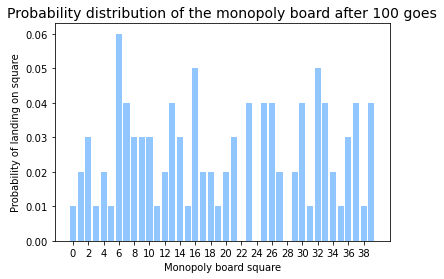

In [453]:
basic_play(100)

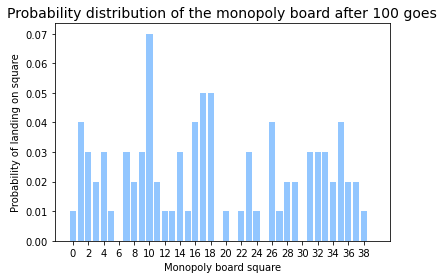

In [799]:
basic_plusjail_play(100)

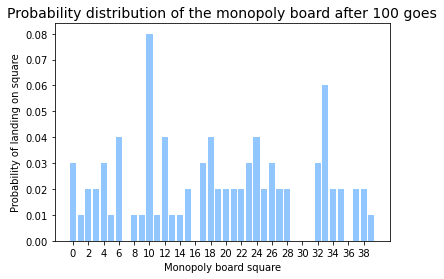

In [1420]:
basic_plusjail_pluscards_play(100)

When limiting to a small number of goes, the distribution is fairly random.

##### Increasing the number of goes dramatically:

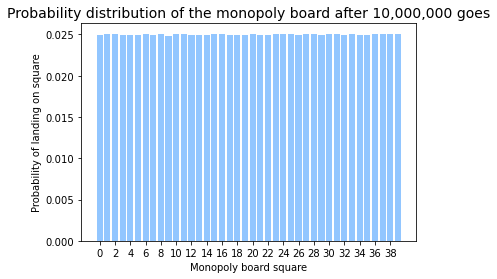

In [456]:
basic_play(10000000)

As n_goes increases, the probability of landing on a given square equalises. This would be expected since when the number of goes is small, you would expect a distribution that is some function of the first distribution I plot of the summed value of two dice, anchored by the starting point. When the number of goes increases significantly the effect of this anchor diminishes.

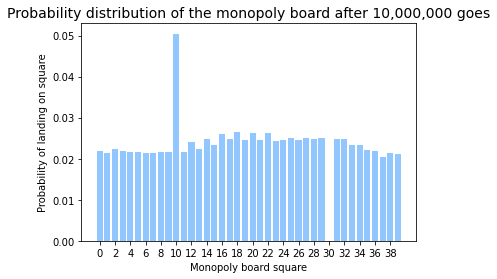

In [455]:
basic_plusjail_play(10000000)

Again, the intuitive result - since you move to jail (square 10) immediately upon landing on square 30, it follows that square 30 has a 0 chance of being 'landed' on, and square 10 at least twice the chance of the other squares since there are (dice aside) two ways of arriving there. There is then a more lumpy distribution on the squares after jail due to the anchoring effect.

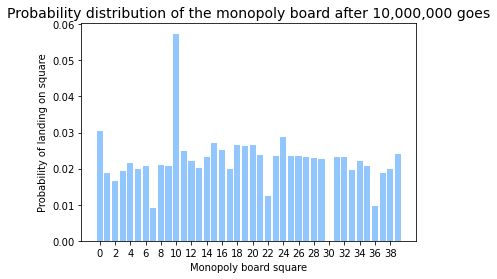

In [1421]:
basic_plusjail_pluscards_play(10000000)

With the deck of cards, we see some similar effects to when jail was introduced: 30 has $p = 0$, 10 now has a higher probability than before (since some of the cards send the player to jail), and the chance / community chest card squares have lower probabilities since several of the cards available to pick up send the player elsewhere.  

# Methodology comment
Most of the scripts I came across online use this method of modelling 1 game over a large number of goes to get a probability distribution. In my mind the problem with this is that as n_goes increases, the probability of landing on a given square equalises (as shown above) - an effect that isn't true of the typical game involving c. 30-40 goes per player. As can be seen from the above graphs, this is most acute when there is a board only. 

A more representative distribution of the probabilities would model a very large number of games each involving a realistic number of goes. I attempt to make this change below.

# Probability distribution method II
Alter the function slightly to return the probability array:

In [90]:
def basic_plusjail_pluscards_play2(n_goes,game):
    n_goes=n_goes
    n_goes_string= '{:,}'.format(n_goes)
    nsquares=40
    board_counters=np.zeros([nsquares],float)
    currentposition=0
    turns=1
    chance_deck.shuffle()
    communitychest_deck.shuffle()
    while turns<n_goes:
        currentposition, in_jail=doubles_play(currentposition)
        currentposition=currentposition%nsquares
        currentposition, in_jail=cardcheck(currentposition,in_jail)
        board_counters[currentposition]+=1
        while in_jail ==1:
            turnsinjail=0
            currentposition,turnsinjail,in_jail=escape_jail(currentposition, in_jail)  
            currentposition=currentposition%nsquares
            turns+=1+turnsinjail
            currentposition, in_jail=cardcheck(currentposition,in_jail)
            board_counters[currentposition]+=1
        else:
            turns+=1        
    for i in range(len(board_counters)):
        board_counters[i]=board_counters[i]/n_goes
    index=list(range(len(board_counters)))
    probs=pd.DataFrame({game:board_counters}, index=index)
    return probs

In [20]:
def monplot2(x,y,n_games_string,n_squares,n_goes):
    plt.style.use('seaborn-pastel')
    plt.bar(x,y)
    plt.xticks(np.arange(min(n_squares), max(n_squares)+1, 2.0))
    plt.xlabel('Monopoly board square')
    plt.ylabel('Probability of landing on square')
    plt.title('Probability distribution of the monopoly board after ' +n_games_string+' games of %d goes'%(n_goes),size=14)

A turn is decided to be when the individual has their go to roll the dice and has arrived at their destination. When introducing jail, the number of turns $\neq$ sum of board counters (pre-scaling) because of the turns used as attempts to get out of jail. This is fine, but I scale the probabilities in the below to the sum of them so that the decimals easily corresond to a % probability.

0.8721317250005678
0.9999999999999998


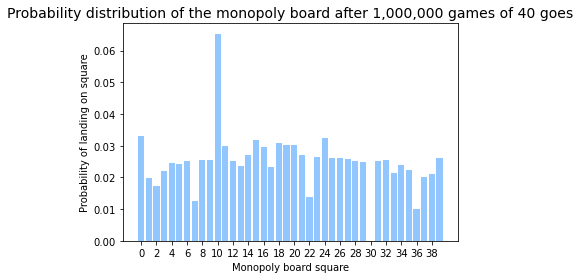

In [118]:
probs_data=pd.DataFrame({'totalG':(np.zeros([40],float))},index=list(range(40)))
n_goes=40
games=1000000
nsquares=40
n_games_string= '{:,}'.format(games)
for game in range(games):
    temp_hold=basic_plusjail_pluscards_play2(n_goes,game)
    probs_data.totalG+=temp_hold[game]
probs_data['Mean']=probs_data.totalG/(games)
print(sum(probs_data.Mean))
probs_data['Mean_adj']=probs_data.Mean/sum(probs_data.Mean)
print(sum(probs_data.Mean_adj))
monplot2(probs_data.index,probs_data.Mean_adj,n_games_string,probs_data.index,n_goes)

# Economics
Now that we have an (approximate) probability distribution for the board, the expected ROIs of each property / utility can be calculated. 

First, a list of the monopoly board squares with their respective acquisition costs:

In [167]:
costs_dict={"Go":0,"Old Kent Road":60,"Community Chest 1":0, "Whitechapel Road": 60, "Income Tax":0,"King's Cross Station":200, 
             "The Angel Islington":100, "Chance 1":0 , "Euston Road":100 , "Pentonville Road":120 , "Jail":0 , "Pall Mall":140,
            "Electric Company":150,"Whitehall":140 , "Northumberland Avenue":160, "Marylebone Station":200, "Bow Street":180,
            "Community Chest 2":0,"Marlborough Street":180 , "Vine Street":200, "Free Parking":0, "The Strand":220, 
            "Chance 2":0, "Fleet Street":220, "Trafalgar Square":240,"Fenchurch St Station":200, "Leicester Square":260,
            "Coventry Street":260, "Water Works":150, "Piccadilly":280, "Go To Jail":0,"Regent Street":300, "Oxford Street":300,
            "Community Chest 3":0, "Bond Street":320, "Liverpool Street Station":200, "Chance 3":0, "Park Lane":350,
            "Super Tax":0, "Mayfair":400}
costs_series=pd.Series(costs_dict)

In [168]:
monopoly_economy=pd.DataFrame(index=list(range(40)))

Rather than a probability distribution that is scaled (as used above), I am more interested in the expected number of times a square will be landed on in a game - i.e. remove the step that scales the probabilities so $\sum Probabilities = 1$ by just using the 'Mean'.

In [169]:
monopoly_economy['Label']=costs_series.index
monopoly_economy['Colour']=""
monopoly_economy['Probability']=probs_data.Mean
monopoly_economy['Purchase']=costs_series.values
monopoly_economy['House_cost']=""

Then, set up a dataframe to store the info. The rents and board position costs are from [here](http://www.jdawiseman.com/papers/trivia/monopoly-rents.html). The cost of building a house varies by colour, so I assign the colours and then the appropriate house cost.

In [170]:
green=[31,32,34]
darkblue=[37,39]
brown=[1,3]
lightblue=[6,8,9]
pink=[11,13,14]
orange=[16,18,19]
red=[21,23,24]
yellow=[26,27,29]

In [171]:
for i in range(len(monopoly_economy)):
    if i in green:
        monopoly_economy.Colour[i]="Green"
        monopoly_economy.House_cost[i]=200
    elif i in darkblue:
        monopoly_economy.Colour[i]="Dark blue"
        monopoly_economy.House_cost[i]=200
    elif i in brown:
        monopoly_economy.Colour[i]="Brown"
        monopoly_economy.House_cost[i]=50
    elif i in lightblue:
        monopoly_economy.Colour[i]="Light blue"
        monopoly_economy.House_cost[i]=50
    elif i in pink:
        monopoly_economy.Colour[i]="Pink"
        monopoly_economy.House_cost[i]=100
    elif i in orange:
        monopoly_economy.Colour[i]="Orange"
        monopoly_economy.House_cost[i]=100
    elif i in red:
        monopoly_economy.Colour[i]="Red"
        monopoly_economy.House_cost[i]=150
    elif i in yellow:
        monopoly_economy.Colour[i]="Yellow"
        monopoly_economy.House_cost[i]=150
    else:
        monopoly_economy.House_cost[i]=""

### Scrape for rent data
In monopoly the marginal cost of a house is constant (i.e. remains == House_cost) and 5 houses = a hotel. The rents, however, do not increase linearly. So need to input the rents that can be charged - I scrape for a csv of these from the [same link as above](http://www.jdawiseman.com/papers/trivia/monopoly-rents.html).

In [172]:
url='http://www.jdawiseman.com/papers/trivia/monopoly-rents.html'
page = requests.get(url)
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
#Check the length of the first **12* rows
[len(T) for T in tr_elements[:20]]

[2, 2, 9, 9, 9, 4, 9, 9, 9, 9, 4, 9, 9, 4, 9, 9, 9, 9, 9, 9]

I am only interested in getting the rows that correspond to properties - the rows with 9 columns.

In [174]:
col=[]
i=0
#List of headers:
for t in tr_elements[2]:
    i+=1
    name=t.text_content()
    #print('%d:"%s"'%(i,name))
    col.append((name,[]))
    
for j in range(3,len(tr_elements)):
    T=tr_elements[j]
    
    #If row is not of size 9 then is ignored 
    if len(T)!=9:
        pass
    else:
        i=0
        #Iterate through each element of the row
        for t in T.iterchildren():
            data=t.text_content() 
            #Check if row is empty
            if i>0:
            #Convert any numerical value to integers
                try:
                    data=int(data)
                except:
                    pass
            #Append the data to the empty list of the i'th column
            col[i][1].append(data)
            #Increment i for the next column
            i+=1

In [175]:
monopoly_scrape_dict={title:column for (title,column) in col}
monopoly_rents=pd.DataFrame(monopoly_scrape_dict)
monopoly_rents = monopoly_rents.rename(columns={'1 hse': 'rent_1house', '2 hses': 'rent_2house' , '3 hses':'rent_3house', 
                                             '4 hses':'rent_4house','Hotel':'rent_5house'})

In [176]:
monopoly_rents.head()

,Property,Cost,M’tg,Site,rent_1house,rent_2house,rent_3house,rent_4house,rent_5house
0,Old Kent Road,60,30,2,10,30,90,160,250
1,Whitechapel Road,60,30,4,20,60,180,320,450
2,The Angel Islington,100,50,6,30,90,270,400,550
3,Euston Road,100,50,6,30,90,270,400,550
4,Pentonville Road,120,60,8,40,100,300,450,600


In [177]:
#Add new columns to store the rent and ROI data
new_cols=['rent_1house','rent_2house','rent_3house','rent_4house','rent_5house']
for i in new_cols:
    monopoly_economy[i]=0
ROI_cols =['ROI_1house','ROI_2house','ROI_3house','ROI_4house','ROI_5house']
for i in ROI_cols:
    monopoly_economy[i]=0.0

In [178]:
for j in range(1,6):
    for i in range(len(monopoly_rents)):
        monopoly_economy['rent_%dhouse'%(j)][monopoly_economy.Label==monopoly_rents.Property[i]]=monopoly_rents['rent_%dhouse'%
                                                                                                                (j)][i]
monopoly_economy.head()

,Label,Colour,Probability,Purchase,House_cost,rent_1house,rent_2house,rent_3house,rent_4house,rent_5house,ROI_1house,ROI_2house,ROI_3house,ROI_4house,ROI_5house
0,Go,,0.03,0,,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
1,Old Kent Road,Brown,0.02,60,50,10,30,90,160,250,0.00,0.00,0.00,0.00,0.00
2,Community Chest 1,,0.02,0,,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
3,Whitechapel Road,Brown,0.02,60,50,20,60,180,320,450,0.00,0.00,0.00,0.00,0.00
4,Income Tax,,0.02,0,,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00


Now that we have the costs of setting up each number of houses on a square, the associated rents and the probability of a player landing on that square, we can then calculate the expected ROIs for each square using the below function.

In [179]:
def ROI(probability,n_goes,purchase,House_cost,no_houses,rent):
    cost=purchase+(House_cost*no_houses)
    income=rent*probability*n_goes
    ROI = income/cost
    ROI = ROI*100
    return ROI

In [180]:
n_goes=40
for i in range(len(monopoly_economy)):
    if monopoly_economy.rent_1house[i]>0:
        for j in range(1,6):
            monopoly_economy['ROI_%dhouse'%(j)][i]=ROI(monopoly_economy.Probability[i],n_goes,monopoly_economy.Purchase[i],
                                                       monopoly_economy.House_cost[i],j,monopoly_economy['rent_%dhouse'%(j)][i])
    else:
        pass

In [181]:
pd.options.display.float_format = "{:,.2f}".format
monopoly_economy.head()

,Label,Colour,Probability,Purchase,House_cost,rent_1house,rent_2house,rent_3house,rent_4house,rent_5house,ROI_1house,ROI_2house,ROI_3house,ROI_4house,ROI_5house
0,Go,,0.03,0,,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
1,Old Kent Road,Brown,0.02,60,50,10,30,90,160,250,6.27,12.92,29.54,42.41,55.58
2,Community Chest 1,,0.02,0,,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00
3,Whitechapel Road,Brown,0.02,60,50,20,60,180,320,450,13.97,28.82,65.87,94.58,111.55
4,Income Tax,,0.02,0,,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00


##### Now that we have the expected ROIs, graph them up:

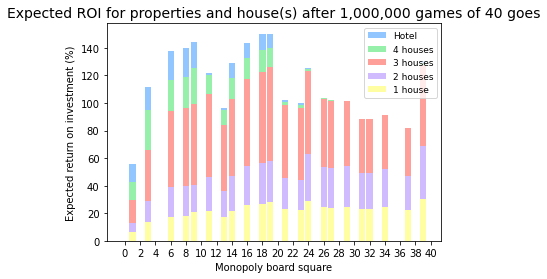

In [182]:
plt.style.use('seaborn-pastel')
plt.bar(monopoly_economy.index,monopoly_economy.ROI_5house,label='Hotel')
plt.bar(monopoly_economy.index,monopoly_economy.ROI_4house,label='4 houses')
plt.bar(monopoly_economy.index,monopoly_economy.ROI_3house,label='3 houses')
plt.bar(monopoly_economy.index,monopoly_economy.ROI_2house,label='2 houses')
plt.bar(monopoly_economy.index,monopoly_economy.ROI_1house,label='1 house')
plt.xticks(np.arange(0,nsquares+1, 2.0))
plt.xlabel('Monopoly board square')
plt.ylabel('Expected return on investment (%)')
plt.title('Expected ROI for properties and house(s) after '+n_games_string+' games of %d goes'%(n_goes),size=14)
#leg=plt.legend(loc='upper right', fontsize=9, ncol=int(threshold_max/step))
leg=plt.legend(loc='best',fontsize=9,ncol=1)

### This is not how Monopoly works, however. 
To build a house, one needs to own all of the squares within a colour. There is then the 'equal build' principle which means that across squares within a colour, one must build to the same level. Therefore, ranking expected ROIs by colour for given levels of build across all 2 - 3 squares  would be more relevant. 

In [183]:
def ROI_colour(colour,n_houses,n_goes):#n_houses set to 5 if hotel
    cost=0
    house_cost=0
    income=0
    house_cost=n_houses*sum(monopoly_economy.House_cost[monopoly_economy.Colour==colour])
    for i in range(len(monopoly_economy)):
        if monopoly_economy.Colour[i]==colour:
            cost+=monopoly_economy.Purchase[i]
        else:
            pass
    total_cost=cost+house_cost
    for j in range(1,6):
        if n_houses==j:
            for i in range(len(monopoly_economy)):
                if monopoly_economy.Colour[i]==colour:
                    income+=n_goes*monopoly_economy.Probability[i]*monopoly_economy['rent_%dhouse'%(j)][i]
                else:
                    pass    
    ROI = income/total_cost
    ROI=ROI*100
    return ROI

In [184]:
colours=[]
for i in range(len(monopoly_economy)):
    if monopoly_economy.Colour[i] =="":
        pass
    elif monopoly_economy.Colour[i] not in colours:
        colours.append(monopoly_economy.Colour[i])
colours_ROI=pd.DataFrame(index=colours)
colourcolumns=['colourROI_1','colourROI_2','colourROI_3','colourROI_4','colourROI_5']
for i in colourcolumns:
    colours_ROI[i]=0.0
    monopoly_economy[i]=0.0
for j in range(1,6):
    for i in range(len(colours_ROI)):
        colours_ROI['colourROI_%d'%(j)][i]=ROI_colour(colours_ROI.index[i],j,n_goes)
for i in range(len(monopoly_economy)):
    for j in range(len(colours_ROI)):
        for k in range(1,6):
            if monopoly_economy.Colour[i]==colours_ROI.index[j]:
                monopoly_economy['colourROI_%d'%(k)][i]=colours_ROI['colourROI_%d'%(k)][j]

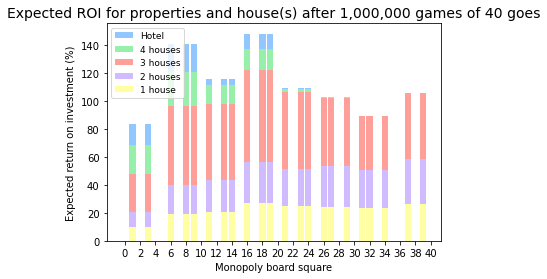

In [185]:
plt.style.use('seaborn-pastel')
plt.bar(monopoly_economy.index,monopoly_economy.colourROI_5,label='Hotel')
plt.bar(monopoly_economy.index,monopoly_economy.colourROI_4,label='4 houses')
plt.bar(monopoly_economy.index,monopoly_economy.colourROI_3,label='3 houses')
plt.bar(monopoly_economy.index,monopoly_economy.colourROI_2,label='2 houses')
plt.bar(monopoly_economy.index,monopoly_economy.colourROI_1,label='1 house')
plt.xticks(np.arange(0,nsquares+1, 2.0))
plt.xlabel('Monopoly board square')
plt.ylabel('Expected return on investment (%)')
plt.title('Expected ROI for properties and house(s) after '+n_games_string+' games of %d goes'%(n_goes),size=14)
leg=plt.legend(loc='upper left',fontsize=9,ncol=1)

Text(0.5, 1.0, 'Expected ROI for groups of properties with hotels after 1,000,000 games of 40 goes')

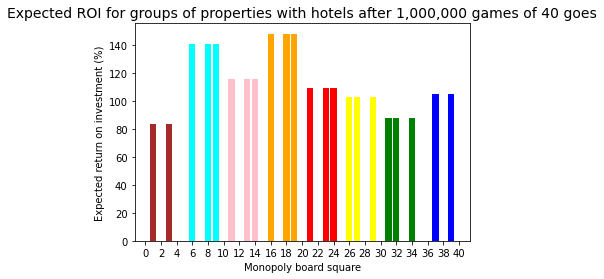

In [186]:
plt.style.use('seaborn-pastel')
plt.bar(brown,monopoly_economy.colourROI_5[brown],color='brown')
plt.bar(lightblue,monopoly_economy.colourROI_5[lightblue],color='cyan')
plt.bar(pink,monopoly_economy.colourROI_5[pink],color='pink')
plt.bar(orange,monopoly_economy.colourROI_5[orange],color='orange')
plt.bar(red,monopoly_economy.colourROI_5[red],color='red')
plt.bar(yellow,monopoly_economy.colourROI_5[yellow],color='yellow')
plt.bar(green,monopoly_economy.colourROI_5[green],color='green')
plt.bar(darkblue,monopoly_economy.colourROI_5[darkblue],color='blue')
plt.xticks(np.arange(0,nsquares+1, 2.0))
plt.xlabel('Monopoly board square')
plt.ylabel('Expected return on investment (%)')
plt.title('Expected ROI for groups of properties with hotels after '+n_games_string+' games of %d goes'%(n_goes),size=14)

For reference, table of ROIs and corresponding squares:

In [197]:
monopoly_economy[['Label','Colour','ROI_5house','colourROI_5']][monopoly_economy.Colour!=""]

,Label,Colour,ROI_5house,colourROI_5
1,Old Kent Road,Brown,55.58,83.57
3,Whitechapel Road,Brown,111.55,83.57
6,The Angel Islington,Light blue,137.39,140.60
8,Euston Road,Light blue,139.70,140.60
9,Pentonville Road,Light blue,144.50,140.60
11,Pall Mall,Pink,122.06,115.79
13,Whitehall,Pink,96.05,115.79
14,Northumberland Avenue,Pink,128.84,115.79
16,Bow Street,Orange,143.51,147.84
18,Marlborough Street,Orange,149.68,147.84


# Conclusion
After all this excitement, I can conclude that:

==> Vine Street and Marlborough Street have the highest ROI when building a hotel on an individual basis

==> **The 'organge' squares have the highest expected ROI on a group basis (the more pertinent result)**

Referring back to the first chart I plot of the distribution of just two dice, this result makes sense - given that jail becomes the most common 'starting' point during a game, the squares that lie in the highest points of the distribution of two dice would be expected to be the most commonly landed on (compared to other property squares).

Whilst this simulation is pretty close to a 'true' game, it could be extended by:

=> Modelling the utilities *(the ammount a player pays the owner varies with number owned and the dice roll, which adds another layer)*

=> Get out of jail cards and money-based cards *(one could try to have a wallet for the player and model ability to buy the houses - I assume that a player can buy a house that they land on - this gets incredibly complicated quite fast as there are then 'tactics' of whether or not to buy a house when landing on it, etc. ...*